In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd
import pickle
import lfpykit
#from lfpykit.eegmegcalc import NYHeadModel
from lfpykit.eegmegcalc import FourSphereVolumeConductor
#import LFPy
from scipy import signal as ss

In [2]:
%matplotlib inline

In [3]:
def bandPassFilter(signal,low=0.1, high=130.):
	order = 2
	b, a = ss.butter(order, [low,high],btype='bandpass',fs=fs)
	y = ss.filtfilt(b, a, signal)
	return y

Calculate EEG/MEG signals from simulation data

In [4]:
file = open('data/Without_ICThalInput/samn_ASSR_wE_1_5_wI_1_0_data.pkl','rb')
data = pickle.load(file)

In [5]:
print(data['simData'].keys())
print(np.shape(data['simData']['dipoleSum']))

dict_keys(['LFP', 'spkt', 'spkid', 'dipoleSum', 't', 'popRates', 'avgRate'])
(400000, 3)


In [6]:
dp = data['simData']['dipoleSum']

In [7]:
print(dp)

[[ 5.25629117e+01 -5.99567352e+02 -2.81184358e-11]
 [ 2.39942901e+02 -3.10855189e+03  2.29011655e-12]
 [ 1.77413276e+02 -2.49524130e+03  3.56231736e-11]
 ...
 [-2.54312605e+04 -1.46843169e+05  9.43156404e-11]
 [-2.55147509e+04 -1.46731465e+05  7.81995923e-11]
 [-2.55531476e+04 -1.46306466e+05  9.84474283e-11]]


In [8]:
# FOUR SPHERE MODEL
radii = [79000., 80000., 85000., 90000.]  # (µm)
sigmas = [0.47, 1.71, 0.02, 0.41]  # (S/m) from Mazza et al., PLoS Comp Biol, 2023
#sigmas = [0.047, 0.171, 0.02, 0.041]  # (S/m) 
r_electrodes = np.array([[0., 90000, 0.]])#, [0., 85000., 0.]]) # (µm)
pos = np.array([0., 78257., 0.])
#L23_pos = np.array([0., 0., 72500.])
sphere_model = FourSphereVolumeConductor(r_electrodes,radii, sigmas)
# # current dipole moment
#p = dp
# # compute potential
signal = sphere_model.get_dipole_potential(dp.transpose(), pos)  # (mV)

In [9]:
np.save('Test-EEG-Signal_woT.npy',signal)

In [10]:
time = np.arange(1000,6000,6000/(np.shape(signal)[1])) 
eeg = signal[0]
dt = 0.1
fs = 1000./dt
startindex = int(1000*(1./dt))

In [11]:
print(np.shape(signal))
print(np.shape(time))
print(np.shape(eeg[startindex:]))

(1, 400000)
(333334,)
(390000,)


In [12]:
nperseg = int(fs/2)
eeg_filt = bandPassFilter(eeg[startindex:])
eeg_freq, eeg_ps = ss.welch(eeg_filt, fs=fs, nperseg=nperseg, window='hann')


ValueError: x and y must have same first dimension, but have shapes (333334,) and (390000,)

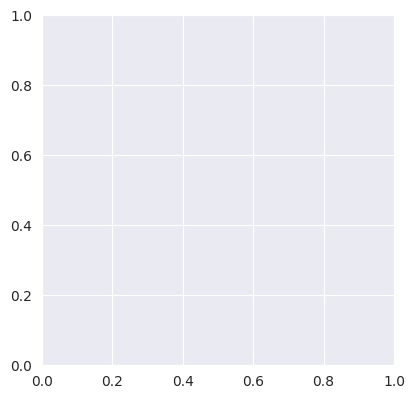

In [13]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.plot(time, eeg_filt, c='k')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('EEG (mV)')
ax2 = fig.add_subplot(222)
ax2.plot(eeg_freq, eeg_ps, c='k')
ax2.set_xlim(0,30)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power (V^2/Hz)')

plt.savefig('EEG-Signal-PSD.png', dpi=200,bbox_inches = "tight")